# Daily

We can specify devices for storage and calculation, such as the CPU or GPU. By default, data are created in the main memory and then use the CPU for calculations.

The deep learning framework requires all input data for calculation to be on the same device, be it CPU or the same GPU.

You can lose significant performance by moving data without care. A typical mistake is as follows: computing the loss for every minibatch on the GPU and reporting it back to the user on the command line (or logging it in a NumPy ndarray) will trigger a global interpreter lock which stalls all GPUs. It is much better to allocate memory for logging inside the GPU and only move larger logs.

-  for Tensorflow-2: You can just use LSTM with no activation specified (ied default to tanh) function and it will automatically use the CuDNN version
- Gradient clipping is a technique to prevent exploding gradients in very deep networks, usually in recurrent neural networks. ... This prevents any gradient to have norm greater than the threshold and thus the gradients are clipped.

### Tips for Activation Functions:
- When using the ReLU function for hidden layers, it is a good practice to use a “He Normal” or “He Uniform” weight initialization and scale input data to the range 0-1 (normalize) prior to training.
- When using the Sigmoid function for hidden layers, it is a good practice to use a “Xavier Normal” or “Xavier Uniform” weight initialization (also referred to Glorot initialization, named for Xavier Glorot) and scale input data to the range 0-1 (e.g. the range of the activation function) prior to training.
- When using the TanH function for hidden layers, it is a good practice to use a “Xavier Normal” or “Xavier Uniform” weight initialization (also referred to Glorot initialization, named for Xavier Glorot) and scale input data to the range -1 to 1 (e.g. the range of the activation function) prior to training.

https://www.tensorflow.org/install/pip#windows-native

The instructions you shared from the TensorFlow website are for creating a new environment with conda, installing the correct versions of CUDA and cuDNN for TensorFlow, and then installing a version of TensorFlow that is compatible with these. It's important to note that it specifies to install a version of TensorFlow less than 2.11, as versions above 2.10 are not supported on the GPU on Windows Native.

If you follow these instructions, it should install everything you need to run TensorFlow with GPU support. The final command is a quick check to ensure TensorFlow can detect your GPU.

Here are the steps:
Open your terminal or Anaconda prompt.
Create a new conda environment (optional, but recommended to avoid package conflicts). You can do this with conda create -n tf_gpu_env python=3.8, then activate it with conda activate tf_gpu_env.
Run the command to install the correct versions of CUDA and cuDNN:

conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0  
 
4. Install a compatible version of TensorFlow:


python -m pip install "tensorflow<2.11"  
 
5. Verify the installation:


python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"  
 
This should return a list with your GPU if everything is installed correctly.

In [1]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, Embedding, Bidirectional, TimeDistributed, BatchNormalization, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.regularizers import l2
from tqdm import tqdm
# from keras_tqdm import TQDMNotebookCallback
import tensorflow.keras.backend as K
import os
import time
import pandas as pd
import numpy as np
import psutil
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
# tf.debugging.set_log_device_placement(True)
print(tf.__version__)
print(tensorflow.keras.__version__)

2.10.1
2.10.0


In [91]:
# tf.debugging.set_log_device_placement(True)
print(tf.__version__)
print(tensorflow.keras.__version__)

2.3.1
2.4.0


In [3]:
import tensorflow as tf  
print("Built with CUDA: ", tf.test.is_built_with_cuda())  
print("Built with GPU Support: ", tf.test.is_built_with_gpu_support())  

Built with CUDA:  True
Built with GPU Support:  True


In [4]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Feb__8_05:53:42_Coordinated_Universal_Time_2023
Cuda compilation tools, release 12.1, V12.1.66
Build cuda_12.1.r12.1/compiler.32415258_0


In [5]:
!nvidia-smi

Tue Mar 26 03:25:27 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.86                 Driver Version: 551.86         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   58C    P8             12W /  115W |     347MiB /   6144MiB |     10%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    print('Using GPU')
    for gpu in gpu_devices[0:2]:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print('Using CPU')
    tf.config.optimizer.set_jit(True)
    print('used: {}% free: {:.2f}GB'.format(psutil.virtual_memory().percent, float(psutil.virtual_memory().free)/1024**3))#@ 

Using GPU


In [7]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use some GPUs
    try:
        tf.config.experimental.set_visible_devices(gpus[0:2], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Visible devices must be set at program startup
        print(e)

1 Physical GPU, 1 Logical GPUs


In [8]:
import psutil
print('used: {}% free: {:.2f}GB'.format(psutil.virtual_memory().percent, float(psutil.virtual_memory().free)/1024**3))

used: 57.9% free: 13.36GB


In [9]:
# Prepare News headlines
def clean_text(df, column):
    import re 
    #("".join(headline)).strip()
    headline = []
    for i in df[column].apply(lambda x: '<s>'+x+'<\s>'):
        headline.append(i)
    return headline

# get sequences of equal length to ensure <\s is at the end
def extract_end(char_seq, seq_len):
    if len(char_seq) > seq_len:
        char_seq = char_seq[:seq_len] #char_seq[-seq_len:]
    return char_seq

# Encode to integers by using ascii 128
def encode2bytes(text):
    #text = tf.strings.unicode_split(text, 'UTF-8').to_list()
    final_list = []
    for sent in text:
        temp_list = []
        for char in sent:
            if ord(char) < 128 :
                temp_list.append(ord(char))
        final_list.append(temp_list)
    return final_list

def split_X_y(text):
    X = []
    y = []
    for i in text:
        X.append(i[0:-1])
        y.append(i[1:])
    return X,y

def to_bytes(sequence):
    byte_text = []
    for i in data.headline:
        i = i.encode('utf-8')
        byte_text.append(i)
    return byte_text

In [10]:
# fix random seed for reproducibility
K.clear_session()
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [11]:
idx = pd.IndexSlice
max_length = 1000

In [12]:
# Get data
# with pd.HDFStore('./model_data.h5', mode = 'r') as data:
#     print(data.keys())
#     data = data['model_data/daily']
#     data.headline = data.headline.apply(lambda x: extract_end(x, max_length))
#     data['headline'] = data.headline.apply(lambda x: '<s>' + x + '<\s')
#     X = data.loc[:,'headline']
#     y = data.loc[:, 'label']
#     y[y<0] = 0
#     print(y.unique())
filename = "firas_lm_dataset.csv"

data = pd.read_csv(filename,
                 header = 0, 
                 encoding="utf-8", encoding_errors="replace", compression = 'gzip', index_col=['ticker','time'])
data.headline = data.headline.apply(lambda x: extract_end(x, max_length))
data['headline'] = data.headline.apply(lambda x: '<s>' + x + '<\s')
data.Signal = data.Signal.replace({1:2, 0:1, -1:0})

In TensorFlow, the `SparseCategoricalCrossentropy` loss function expects the labels to be integers in the range [0, num_classes - 1]. In your case, the labels are [0, 1, 2], which do not meet this requirement.  
   
So, you have two options if you want to keep your labels as [0, 1, 2]:  
   
1. Custom loss function: You can write a loss function that can handle your labels correctly. This requires a good understanding of how to compute the loss for your specific problem.  
   
2. One-hot encoding: This is a process by which categorical variables are converted into a form that could be provided to machine learning algorithms to improve their performance. In your case, you could convert your labels [0, 1, 2] into a binary vector representation:  
  
   -  0 could be [1, 0, 0]  
   -  1 could be [0, 1, 0]  
   -  2 could be [0, 0, 1]  
   
Then, you can use the `CategoricalCrossentropy` loss function, which works with one-hot encoded labels.   
  
Here is an example of how to one-hot encode your labels using `tensorflow.keras.utils.to_categorical`:  
   
```python  
from tensorflow.keras.utils import to_categorical  
   
# Assuming y is your array of labels  
y_encoded = to_categorical(y + 1, num_classes=3)  #[-1,0,1]
y_encoded = to_categorical(y, num_classes=3)  #[0,1,2]
```  
   
In this case, we are adding 1 to all labels to transform them into the range [0, 2] before one-hot encoding. The resulting `y_encoded` will be suitable for training your model with `CategoricalCrossentropy` loss.

In [13]:
pd.concat([data.head(),data.tail()])

headline  \
ticker time                                                            
A      2019-07-11  <s>Delivery Of Ionization Auxiliary Equipment ...   
       2019-07-12  <s>Epa Do Agilent 7250 Gc/q-tof Mass Spectrome...   
       2019-07-16  <s>AGILENT TECHNOLOGIES INC <A.N>: EVERCORE IS...   
       2019-07-17  <s>Procurement Of Spares And Consumables For T...   
       2019-07-18  <s>NYSE ORDER IMBALANCE <A.N> 68900.0 SHARES O...   
ZTS    2020-09-28  <s>NYSE ORDER IMBALANCE <ZTS.N> 59715.0 SHARES...   
       2020-09-30  <s>Zoetis to Host Webcast and Conference Call ...   
       2020-10-07  <s>Sachem Head takes $1.2 bln position in Elan...   
       2020-10-09  <s>NYSE ORDER IMBALANCE <ZTS.N> 230640.0 SHARE...   
       2020-10-12  <s>ZOETIS INC <ZTS.N>: CREDIT SUISSE RAISES PR...   

                          Open        Close   returns  label  Signal  \
ticker time                                                            
A      2019-07-11  1146.160034  1144.079956  0.001101    1.0       1   
       2019-07-12  1142.930054  1145.339966  0.004514    1.0       1   
       2019-07-16  1146.729980  1153.459961 -0.005826    0.0       1   
       2019-07-17  1150.920044  1146.739990  0.000436    1.0       1   
       2019-07-18  1142.000000  1147.239990 -0.013676    0.0       0   
ZTS    2020-09-28   162.380005   161.320007  0.007191    1.0       1   
       2020-09-30   162.919998   165.369995 -0.008103    0.0       1   
       2020-10-07   163.350006   159.910004  0.020386    1.0       2   
       2020-10-09   163.979996   165.429993  0.018860    1.0       2   
       2020-10-12   167.080002   168.550003 -0.019163    0.0       0   

                   n_Characters  Partition  
ticker time                                 
A      2019-07-11          1441       Test  
       2019-07-12           278       Test  
       2019-07-16            78       Test  
       2019-07-17           159       Test  
       2019-07-18            53       Test  
ZTS    2020-09-28            56      Train  
       2020-09-30           139      Train  
       2020-10-07           110  Inference  
       2020-10-09            57  Inference  
       2020-10-12           210  Inference

In [14]:
data.loc[idx[:,'2020-10-01':], ].head(50)

headline  \
ticker time                                                            
A      2020-10-01            <s>AGILENT TECHNOLOGIES, INC. -- S-8<\s   
       2020-10-02  <s>The Replacement Of Sampler Handler Assembly...   
       2020-10-08  <s>Agilent Measurement Suite celebrates early ...   
       2020-10-09  <s>Spare Parts For Equipment Manufactured By A...   
       2020-10-13  <s>NYSE ORDER IMBALANCE <A.N> 50070.0 SHARES O...   
AAL    2020-10-01  <s>American Airlines says it will begin furlou...   
       2020-10-02  <s>Refinitiv Newscasts - Airlines push ahead w...   
       2020-10-05  <s>American Airlines Adds Costa Rica to Prefli...   
       2020-10-06  <s>AMERICAN AIRLINES DELAYS PLAN TO START BOEI...   
       2020-10-07  <s>BUZZ-U.S. airlines rebound as Trump pushes ...   
       2020-10-08  <s>BUZZ-U.S. STOCKS ON THE MOVE-Eaton Vance, I...   
       2020-10-09  <s>MCCONNELL SAYS AIRLINE AID SHOULD BE PART O...   
       2020-10-12  <s>Refinitiv Newscasts - Flying during the COV...   
AAP    2020-10-01  <s>Hot Shot’s Secret Everyday Diesel Treatment...   
       2020-10-02  <s>Advance Auto Parts Names Mann + Hummel 2020...   
       2020-10-06  <s>ADVANCE AUTO PARTS INC <AAP.N>: JP MORGAN R...   
AAPL   2020-10-01  <s>Zuckerberg eyes augmented reality as the fu...   
       2020-10-02  <s>Apple working on foldable iPhone with 'self...   
       2020-10-05  <s>Apple, Google tracing apps limited Google, ...   
       2020-10-06  <s>BUZZ-Logitech shares slip on reports of App...   
       2020-10-07  <s>UPDATE 6-U.S. lawmakers detail Big Tech's m...   
       2020-10-08  <s>Pomerantz Law Firm Achieves Victory on Beha...   
       2020-10-09  <s>Refinitiv Newscasts - Blockchain Interviews...   
       2020-10-12  <s>PRESS DIGEST- Financial Times - Oct. 12 APP...   
       2020-10-13  <s>APPLE INC SAYS EVERY NEW IPHONE WILL FEATUR...   
ABBV   2020-10-01  <s>Public coverage of AbbVie's SKYRIZI® for th...   
       2020-10-02  <s>AbbVie to Present New Data From 15 Abstract...   
       2020-10-05  <s>SHAREHOLDER ACTION REMINDER: The Schall Law...   
       2020-10-06  <s>AbbVie to Host Third-Quarter 2020 Earnings ...   
       2020-10-07  <s>Allergan Aesthetics, an AbbVie Company, Acq...   
       2020-10-08  <s>Allergan, an AbbVie Company, and Von Miller...   
       2020-10-09  <s>Allergan Aesthetics To Present Data From 4 ...   
       2020-10-12  <s>AbbVie - Allergan Aesthetics to Present Dat...   
       2020-10-13  <s>NIH SAYS TRIAL WILL TEST RISANKIZUMAB, IN C...   
ABC    2020-10-01  <s>BRIEF-HHS Says Gilead Anticipates Producing...   
       2020-10-05  <s>AmerisourceBergen Corporation - ION & IPN S...   
       2020-10-06  <s>AmerisourceBergen Announces Date and Time f...   
       2020-10-12  <s>AMERISOURCEBERGEN CORP <ABC.N> : EVERCORE I...   
       2020-10-13  <s>MWI Animal Health Selects CVP Impack Automa...   
ABMD   2020-10-08  <s>TCT Connect to Highlight How Impella Enable...   
       2020-10-09  <s>ABIOMED INC -- SC 13G/A ABIOMED - TCT Conne...   
       2020-10-12  <s>ABIOMED INC <ABMD.O> : SVB LEERINK CUTS TAR...   
ABT    2020-10-01  <s>Refinitiv Newscasts - Navigating the econom...   
       2020-10-02  <s>Abbott's Libre 3 Receives CE Mark, Boosts C...   
       2020-10-05  <s>NYSE ORDER IMBALANCE <ABT.N> 227300.0 SHARE...   
       2020-10-06  <s>CANADA HAS SIGNED A DEAL WITH ABBOTT RAPID ...   
       2020-10-07  <s>ABBOTT LABORATORIES <ABT.N> : WELLS FARGO R...   
       2020-10-08  <s>Allergy Immunotherapies Market - Actionable...   
       2020-10-09  <s>ABBOTT LABORATORIES <ABT.N> : JP MORGAN RAI...   
       2020-10-12  <s>REG - Allergy Therapeutics  - Holding(s) in...   

                         Open       Close   returns  label  Signal  \
ticker time                                                          
A      2020-10-01  101.769997  101.220001 -0.011954    0.0       0   
       2020-10-02  100.209999  100.010002  0.031097    1.0       2   
       2020-10-08  104.199997  104.

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 110905 entries, ('A', '2019-07-11') to ('ZTS', '2020-10-12')
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   headline      110905 non-null  object 
 1   Open          110905 non-null  float64
 2   Close         110905 non-null  float64
 3   returns       110905 non-null  float64
 4   label         110905 non-null  float64
 5   Signal        110905 non-null  int64  
 6   n_Characters  110905 non-null  int64  
 7   Partition     110905 non-null  object 
dtypes: float64(4), int64(2), object(2)
memory usage: 7.2+ MB


In [16]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,110905.0,179.949653,1195.936822,3.220000,41.509998,80.650002,141.729996,29440.470703
Close,110905.0,179.970824,1195.748259,3.020000,41.470001,80.570000,141.729996,29423.310547
returns,110905.0,0.000567,0.032472,-0.998369,-0.011305,0.000974,0.012553,0.429971
label,110905.0,0.527046,0.499270,0.000000,0.000000,1.000000,1.000000,1.000000
Signal,110905.0,1.025066,0.749885,0.000000,0.000000,1.000000,2.000000,2.000000
n_Characters,110905.0,379.054686,638.605787,5.000000,72.000000,158.000000,384.000000,11466.000000


In [17]:
X = data.loc[:,'headline']
y = data.loc[:, 'Signal']
X.shape, y.shape

((110905,), (110905,))

In [18]:
# Train / Test / Infer: Test  which is Validation here: 2019-07-08--->2019-08-01, Infer on 
X_train, X_test, X_infer = X.loc[idx[:,'2019-08-01':'2020-10-01'], ], X.loc[idx[:,:'2019-08-01'], ], X.loc[idx[:,'2020-10-01':], ]
y_train, y_test, y_infer = y.loc[idx[:,'2019-08-01':'2020-10-01'], ], y.loc[idx[:,:'2019-08-01'], ], y.loc[idx[:,'2020-10-01':], ]

In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_infer.shape, y_infer.shape

((103065,), (5697,), (103065,), (5697,), (2874,), (2874,))

In [20]:
print('y labels:\n', y.value_counts())
print('Train Labels:\n', y_train.value_counts())
print('Test Labels:\n', y_test.value_counts())
print('Inference Labels:\n', y_infer.value_counts())
print("Train Ratio %.2f" % (len(X_train)/ len(X)))

y labels:
 Signal
1    48471
2    32607
0    29827
Name: count, dtype: int64
Train Labels:
 Signal
1    44324
2    30642
0    28099
Name: count, dtype: int64
Test Labels:
 Signal
1    3263
0    1371
2    1063
Name: count, dtype: int64
Inference Labels:
 Signal
1    1226
2    1067
0     581
Name: count, dtype: int64
Train Ratio 0.93


In [21]:
# ENCODE ORDINAL
X_train = [i.encode('utf-8') for i in X_train]
X_test = [i.encode('utf-8') for i in X_test]
X_infer = [i.encode('utf-8') for i in X_infer]
# X_encode = encode2bytes(X)

In [22]:
X_train[0:5]

[b'<s>Agilent Settles Key Intellectual Property Case in China AGILENT SETTLES KEY INTELLECTUAL PROPERTY CASE IN CHINA Agilent Settles Key Intellectual Property Case in China EChrom and Pannatek Admit to using Agilent Technology Without Permission, Agree to Pay Damages and Cease Using Agilent Technology AGILENT TECHNOLOGIES- CO REACHED AGREEMENT WITH ECHROM AND PANNATEK, AS WELL AS CERTAIN FORMER AGILENT EMPLOYEES, REGARDING AN INTELLECTUAL PROPERTY DISPUTE BRIEF-Agilent Settles Key Intellectual Property Case In China Agilent Companion Diagnostic Gains Expanded FDA Approval in Esophageal Squamous Cell Carcinoma<\\s',
 b'<s>NYSE ORDER IMBALANCE <A.N> 65800.0 SHARES ON BUY SIDE<\\s',
 b'<s>AGILENT TECHNOLOGIES INC SEC Filings files Form -- 4<\\s',
 b'<s>Turbo Pump Controller (model No. X3506 64002 Make Agilent NYSE ORDER IMBALANCE <A.N> 51900.0 SHARES ON SELL SIDE<\\s',
 b'<s>Supplying Of Spares With Fitting And Fixing For 70 Nos. Tri-cycle Paddle Van In Ward Nos.-63,64,65,66 & 67, Under 

In [23]:
#Tokenize
import json
with open('../CharModelDev/CharModel-v2/Tokenizer.json', encoding='utf-8') as f:
    data = json.load(f)
    tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(data)
with open('../CharModelDev/CharModel-v2/index2char.json', encoding='utf-8') as f:
    index2char = json.load(f)
    index2char = dict((int(k),int(v)) for k,v in index2char.items())
char2index = dict((int(v),int(k)) for k,v in index2char.items())
tokenizer.word_index = char2index
# with open('index2char.json', 'w', encoding='utf-8') as f:
#         json.dump(index2char, f, ensure_ascii=False, indent=4) 


In [24]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_infer = tokenizer.texts_to_sequences(X_infer)

### How to convert back to readable form:

In [25]:
print(X_train[0])
print(bytes(list(map(index2char.get, X_train[0]))).decode('utf-8'))

[31, 86, 33, 36, 74, 76, 79, 72, 81, 87, 3, 54, 72, 87, 87, 79, 72, 86, 3, 46, 72, 92, 3, 44, 81, 87, 72, 79, 79, 72, 70, 87, 88, 68, 79, 3, 51, 85, 82, 83, 72, 85, 87, 92, 3, 38, 68, 86, 72, 3, 76, 81, 3, 38, 75, 76, 81, 68, 3, 36, 42, 44, 47, 40, 49, 55, 3, 54, 40, 55, 55, 47, 40, 54, 3, 46, 40, 60, 3, 44, 49, 55, 40, 47, 47, 40, 38, 55, 56, 36, 47, 3, 51, 53, 50, 51, 40, 53, 55, 60, 3, 38, 36, 54, 40, 3, 44, 49, 3, 38, 43, 44, 49, 36, 3, 36, 74, 76, 79, 72, 81, 87, 3, 54, 72, 87, 87, 79, 72, 86, 3, 46, 72, 92, 3, 44, 81, 87, 72, 79, 79, 72, 70, 87, 88, 68, 79, 3, 51, 85, 82, 83, 72, 85, 87, 92, 3, 38, 68, 86, 72, 3, 76, 81, 3, 38, 75, 76, 81, 68, 3, 40, 38, 75, 85, 82, 80, 3, 68, 81, 71, 3, 51, 68, 81, 81, 68, 87, 72, 78, 3, 36, 71, 80, 76, 87, 3, 87, 82, 3, 88, 86, 76, 81, 74, 3, 36, 74, 76, 79, 72, 81, 87, 3, 55, 72, 70, 75, 81, 82, 79, 82, 74, 92, 3, 58, 76, 87, 75, 82, 88, 87, 3, 51, 72, 85, 80, 76, 86, 86, 76, 82, 81, 15, 3, 36, 74, 85, 72, 72, 3, 87, 82, 3, 51, 68, 92, 3, 39, 

Headlines length: 
Mean 297.05 words (Std 298.79) max 1006


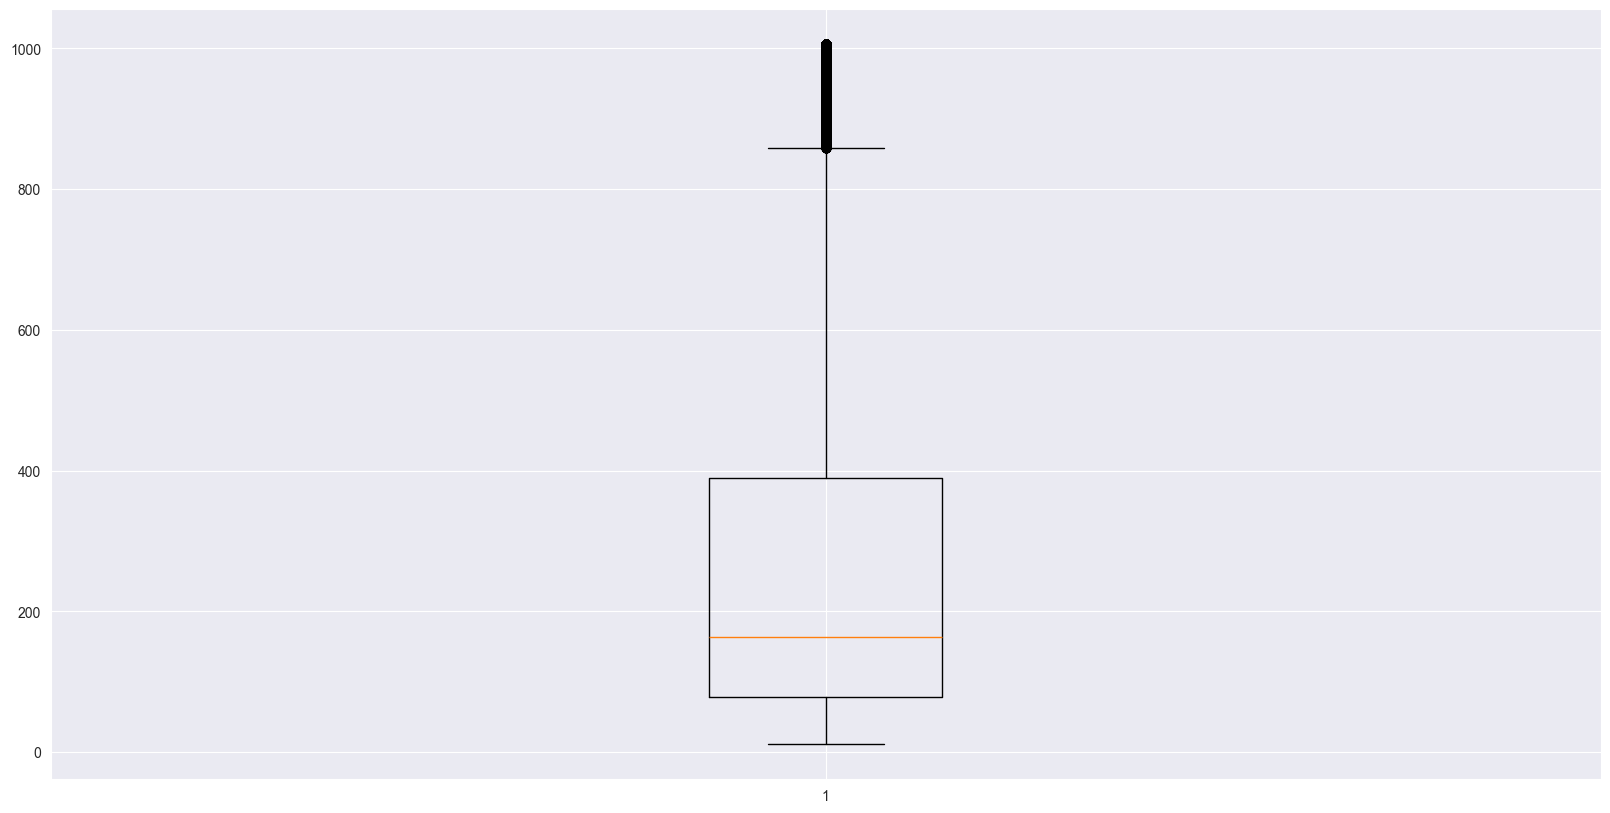

In [26]:
# Summarize headlines length
print("Headlines length: ")
result = [len(sentence) for sentence in X]
print("Mean %.2f words (Std %.2f) max %d" % (np.mean(result), np.std(result), max(result)))
# plot review length
plt.figure(figsize=(20,10));
plt.boxplot(result)
plt.show()

In [27]:
# prepadded to solve for forward propagation not masking
max_sentence_len = max(map(len, X))
X_train = pad_sequences(X_train, maxlen =  max(map(len, X_train)), padding = 'pre', truncating='pre')
X_test = pad_sequences(X_test, maxlen = max(map(len, X_test)), padding = 'pre', truncating='pre')
X_infer = pad_sequences(X_infer, maxlen = max(map(len, X_infer)), padding = 'pre', truncating='pre')
X_train.shape, X_test.shape, X_infer.shape
# X_padded = pad_sequences(X_encode, maxlen = max_sentence_len, padding = 'pre', truncating='pre')

((103065, 1116), (5697, 1023), (2874, 1032))

In [28]:
# Our vectorized labels : BINARY
# train_labels = np.asarray(y_train).astype('float32').reshape((-1,1)) #sparsecategorical requires (-1) not (-1,1)
# test_labels = np.asarray(test_labels_one_hot).astype('float32').reshape((-1,1))
# infer_labels = np.asarray(y_infer).astype('float32').reshape((-1,1))

#MULTI-CLASS
from tensorflow.keras.utils import to_categorical 

  
train_labels = to_categorical(y_train)  
test_labels = to_categorical(y_test, num_classes=3)  
infer_labels = to_categorical(y_infer, num_classes=3)  
train_labels.shape, test_labels.shape, infer_labels.shape

((103065, 3), (5697, 3), (2874, 3))

In [116]:
y_train[:5],to_categorical(y_train)[:5]

(ticker  time      
 A       2019-08-01    0
         2019-08-02    0
         2019-08-05    2
         2019-08-06    1
         2019-08-07    2
 Name: Signal, dtype: int64,
 array([[1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.]], dtype=float32))

In [29]:
train_seq_data = tf.data.Dataset.from_tensor_slices((X_train,train_labels))
test_seq_data = tf.data.Dataset.from_tensor_slices((X_test,test_labels))
infer_seq_data = tf.data.Dataset.from_tensor_slices((X_infer,infer_labels))

In [30]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def configure_dataset(dataset):
  return dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [31]:
batch_size = 32

train_seq_data = train_seq_data.batch(batch_size, drop_remainder=True, name = 'train')
test_seq_data = test_seq_data.batch(batch_size, drop_remainder=True, name = 'test')
infer_seq_data = infer_seq_data.batch(batch_size, drop_remainder=True, name = 'inference')
print('Train Set Shape: ', train_seq_data, '\nTest Set Shape: ', test_seq_data)

Train Set Shape:  <BatchDataset element_spec=(TensorSpec(shape=(32, 1116), dtype=tf.int32, name=None), TensorSpec(shape=(32, 3), dtype=tf.float32, name=None))> 
Test Set Shape:  <BatchDataset element_spec=(TensorSpec(shape=(32, 1023), dtype=tf.int32, name=None), TensorSpec(shape=(32, 3), dtype=tf.float32, name=None))>


In [32]:
print('Check train set:')
for input_txt, target_txt in  test_seq_data.take(1):
    print('--------------------------------Headline--------------------------------')
    print(input_txt.numpy())
    # print(bytes(list(map(index2char.get, y[num]))).decode('utf-8'))
#     print(''.join(index2char[input_txt.numpy()]))
    print('\n')
    print(target_txt.numpy())

Check train set:
--------------------------------Headline--------------------------------
[[ 0  0  0 ... 31 63 86]
 [ 0  0  0 ... 31 63 86]
 [ 0  0  0 ... 31 63 86]
 ...
 [ 0  0  0 ... 31 63 86]
 [ 0  0  0 ... 31 63 86]
 [ 0  0  0 ... 31 63 86]]


[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [33]:
# with tf.device('CPU'):
train_seq_data = configure_dataset(train_seq_data)
test_seq_data = configure_dataset(test_seq_data)
infer_seq_data = configure_dataset(infer_seq_data)

In [34]:
train_seq_data, test_seq_data, infer_seq_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(32, 1116), dtype=tf.int32, name=None), TensorSpec(shape=(32, 3), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(32, 1023), dtype=tf.int32, name=None), TensorSpec(shape=(32, 3), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(32, 1032), dtype=tf.int32, name=None), TensorSpec(shape=(32, 3), dtype=tf.float32, name=None))>)

In [35]:
# def create_language_model(batch_size):
#     model = Sequential(name = 'CharLSTM')
#     model.add(Embedding(127, 256,batch_input_shape=[batch_size, None], 
#                         mask_zero=True, name ='EmbedLayer'))
#     model.add(Bidirectional(LSTM(1024, return_sequences=True,stateful=False,
#                                  recurrent_initializer='glorot_uniform'), merge_mode ='ave',name = 'BiLSTM'))
#     model.add(TimeDistributed(Dense(127, name = 'TimeDistDense')))
#     model.compile(optimizer=tf.optimizers.SGD(learning_rate=1e-1), 
#                   loss = tf.losses.SparseCategoricalCrossentropy(from_logits = True))
#     return model
# #Compile then load weights
# checkpoint_dir = './training_checkpoints_CharWeights'

# ChaRmodel = create_language_model(batch_size=None)

# print(tf.train.latest_checkpoint(checkpoint_dir))
# ChaRmodel.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

# ChaRmodel.build(tf.TensorShape([1,None]))

# # Get layers to intialize classification model
# embeddings = ChaRmodel.layers[0].get_weights()[0]
# lstm = ChaRmodel.layers[1].get_weights()[0]
# print(embeddings.shape, lstm.shape)

ChaRmodel = tf.keras.models.load_model('../CharModelDev/CharModel-v2/CharLM.h5')
ChaRmodel.summary()

Model: "CharLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EmbedLayer (Embedding)      (128, None, 256)          47360     
                                                                 
 BiLSTM (Bidirectional)      (128, None, 2048)         10493952  
                                                                 
 time_distributed (TimeDistr  (128, None, 185)         379065    
 ibuted)                                                         
                                                                 
Total params: 10,920,377
Trainable params: 10,920,377
Non-trainable params: 0
_________________________________________________________________


In [36]:
len(char2index)

185

In [37]:
def direction_model():
    model = Sequential(name = 'RNNStocks')
    model.add(Embedding(input_dim = 185, output_dim = 256,batch_input_shape=[None, None],
                        mask_zero = True, name ='EmbedLayer'))
    model.add(Bidirectional(LSTM(1024,
                                 return_sequences=False,stateful=False, 
                                 recurrent_initializer='glorot_uniform'), merge_mode ='concat',name = 'BiLSTM'))
    #final state encodes full representation of a single passed headine
    model.add(BatchNormalization(name='BatchNormal')) #After RNN(S-shape activation-f(x) / Before ReLU(Non-Gaussian))
#     model.add(tf.keras.layers.Masking(mask_value=0))
    model.add(Dense(512, name = 'FullConnected', kernel_initializer='he_normal')) 
    model.add(tf.keras.layers.LeakyReLU()) #controls vanishing gradients:f(x) =  a * (exp(x) - 1.) for x < 0 ; f(x) = x for x >= 0
    model.add(BatchNormalization(name='BatchNormal2'))
    model.add(Dense(3, activation='softmax',name='Output'))
    model.compile(optimizer=tf.optimizers.Adadelta(learning_rate = 1e-04), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy',  tf.keras.metrics.AUC(name='AUC')])
    return model

In [38]:
# previous_training = tf.keras.models.load_model('daily.h5').get_weights()

In [39]:
 # batch size of 128 headlines is used to space out weight updates for our large data
epochs = 100
# # with strategy.scope():
# gpus = tf.config.experimental.list_logical_devices('GPU')
# if gpus:
#   # Replicate your computation on multiple GPUs
#   for gpu in gpus:
with tf.device('GPU'):
    model = direction_model()
    checkpoint_dir = './training_checkpoints_CharWeights_V2'
    # print(tf.train.latest_checkpoint(checkpoint_dir))
    # model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
    model.layers[0].set_weights(ChaRmodel.layers[0].get_weights())
    model.layers[1].set_weights(ChaRmodel.layers[1].get_weights())

In [40]:
#Freeze Language Model Layers for initial training of Added Layers:
# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:2]:
    layer.trainable =  False

In [41]:
model.summary()

Model: "RNNStocks"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EmbedLayer (Embedding)      (None, None, 256)         47360     
                                                                 
 BiLSTM (Bidirectional)      (None, 2048)              10493952  
                                                                 
 BatchNormal (BatchNormaliza  (None, 2048)             8192      
 tion)                                                           
                                                                 
 FullConnected (Dense)       (None, 512)               1049088   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 BatchNormal2 (BatchNormaliz  (None, 512)              2048      
 ation)                                                  

In [42]:
print(np.all(model.get_layer('EmbedLayer').get_weights()[0] == ChaRmodel.get_layer('EmbedLayer').get_weights()[0] ))
for i in range(0, len(model.get_layer('BiLSTM').get_weights())):
    print(np.all(model.get_layer('BiLSTM').get_weights()[i] == ChaRmodel.get_layer('BiLSTM').get_weights()[i]))

True
True
True
True
True
True
True


In [43]:
print([layer.supports_masking for layer in model.layers])
print([layer.supports_masking for layer in ChaRmodel.layers])

[True, True, True, True, True, True, True]
[True, True, True]


### Test Model Pre training it

In [44]:
sample = 'MSFT rallying after last earnings call' 
sample = '<s>' + sample + '<\s' 
print(sample)
sample = [i.encode('utf-8') for i in sample]
sample = tokenizer.texts_to_sequences(sample)
print(sample)
sample = tf.squeeze(sample)
sample = tf.expand_dims(sample, 0).numpy()
sample.shape

<s>MSFT rallying after last earnings call<\s
[[31], [86], [33], [48], [54], [41], [55], [3], [85], [68], [79], [79], [92], [76], [81], [74], [3], [68], [73], [87], [72], [85], [3], [79], [68], [86], [87], [3], [72], [68], [85], [81], [76], [81], [74], [86], [3], [70], [68], [79], [79], [31], [63], [86]]


(1, 44)

In [45]:
padded_sample = 'MSFT rallying after last earnings call' 
padded_sample = '<s>' + padded_sample + '<\s' + chr(0) * 20
print(padded_sample)
padded_sample = [i.encode('utf-8') for i in padded_sample]
padded_sample = tokenizer.texts_to_sequences(padded_sample)
print(padded_sample)
padded_sample = tf.squeeze(padded_sample)
padded_sample = tf.expand_dims(padded_sample, 0).numpy()
padded_sample.shape

<s>MSFT rallying after last earnings call<\s                    
[[31], [86], [33], [48], [54], [41], [55], [3], [85], [68], [79], [79], [92], [76], [81], [74], [3], [68], [73], [87], [72], [85], [3], [79], [68], [86], [87], [3], [72], [68], [85], [81], [76], [81], [74], [86], [3], [70], [68], [79], [79], [31], [63], [86], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]


(1, 64)

In [46]:
print(model(sample).numpy())
print('vs')
print(model(padded_sample).numpy())

[[0.24812579 0.43181646 0.32005772]]
vs
[[0.24812579 0.43181646 0.32005772]]


In [47]:
1/(1+np.exp(-0.53))

0.6294831119673949

### Compute PreTraining Baseline Metrics

In [52]:
# TEST DATA
initial_epochs = 10
validation_steps= int(X_test.shape[0] / batch_size)

initial_loss, initial_accuracy, intial_AUC = model.evaluate(test_seq_data, steps = validation_steps, workers = -1)

89/89 [==============================] - 49s 525ms/step - loss: 1.4554 - accuracy: 0.1993 - AUC: 0.4754


In [53]:
print(f'Initial loss: {initial_loss:.2f} | initial Accuracy : {initial_accuracy:.2%} | Initial AUC: {intial_AUC:.2%}')

Initial loss: 1.46 | initial Accuracy : 19.93% | Initial AUC: 47.54%


In [54]:
# VALIDATION DATA
validation_step_2 = int(X_infer.shape[0] / batch_size)

initial_loss, initial_accuracy, intial_AUC = model.evaluate(infer_seq_data, steps = validation_step_2)

44/44 [==============================] - 25s 543ms/step - loss: 1.2710 - accuracy: 0.3810 - AUC: 0.5884


In [55]:
print(f'Initial loss: {initial_loss:.2f} | initial Accuracy : {initial_accuracy:.2%} | Initial AUC: {intial_AUC:.2%}')

Initial loss: 1.27 | initial Accuracy : 38.10% | Initial AUC: 58.84%


### Warm Start Training
* Pretrained weights should be freezed, for the intial tuning of new added final layers to avoid large gradient updates that can eliminate the pretrained results from the language model.

In [48]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=10,
                               mode='max',
                               restore_best_weights=True)
csv_logs = tf.keras.callbacks.CSVLogger('./daily_log.csv', separator=",", append=False)

In [49]:
history = model.fit(train_seq_data,
                    epochs=30,
                    validation_data = test_seq_data,
                    callbacks=[early_stopping, csv_logs])

Epoch 1/30
3220/3220 [==============================] - 8973s 3s/step - loss: 1.3478 - accuracy: 0.3367 - AUC: 0.5020 - val_loss: 1.3166 - val_accuracy: 0.3169 - val_AUC: 0.4831
Epoch 2/30
3220/3220 [==============================] - 8786s 3s/step - loss: 1.2439 - accuracy: 0.3371 - AUC: 0.5025 - val_loss: 1.2497 - val_accuracy: 0.3192 - val_AUC: 0.4857
Epoch 3/30
3220/3220 [==============================] - 8845s 3s/step - loss: 1.2072 - accuracy: 0.3373 - AUC: 0.5038 - val_loss: 1.2224 - val_accuracy: 0.3225 - val_AUC: 0.4833
Epoch 4/30
3220/3220 [==============================] - 9227s 3s/step - loss: 1.1866 - accuracy: 0.3379 - AUC: 0.5048 - val_loss: 1.2011 - val_accuracy: 0.3225 - val_AUC: 0.4841
Epoch 5/30
3220/3220 [==============================] - 9348s 3s/step - loss: 1.1736 - accuracy: 0.3386 - AUC: 0.5066 - val_loss: 1.1880 - val_accuracy: 0.3208 - val_AUC: 0.4842
Epoch 6/30
3220/3220 [==============================] - 9387s 3s/step - loss: 1.1656 - accuracy: 0.3408 - AUC:

In [50]:
def plot_learning_curves(df):
    fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
    df[['loss', 'val_loss']].plot(ax=axes[0], title='Cross-Entropy')
    df[['accuracy', 'val_accuracy']].plot(ax=axes[1], title='Accuracy')
    for ax in axes:
        ax.legend(['Training', 'Validation'])
    sns.despine()        
    fig.tight_layout();

In [51]:
metrics = pd.DataFrame(history.history)

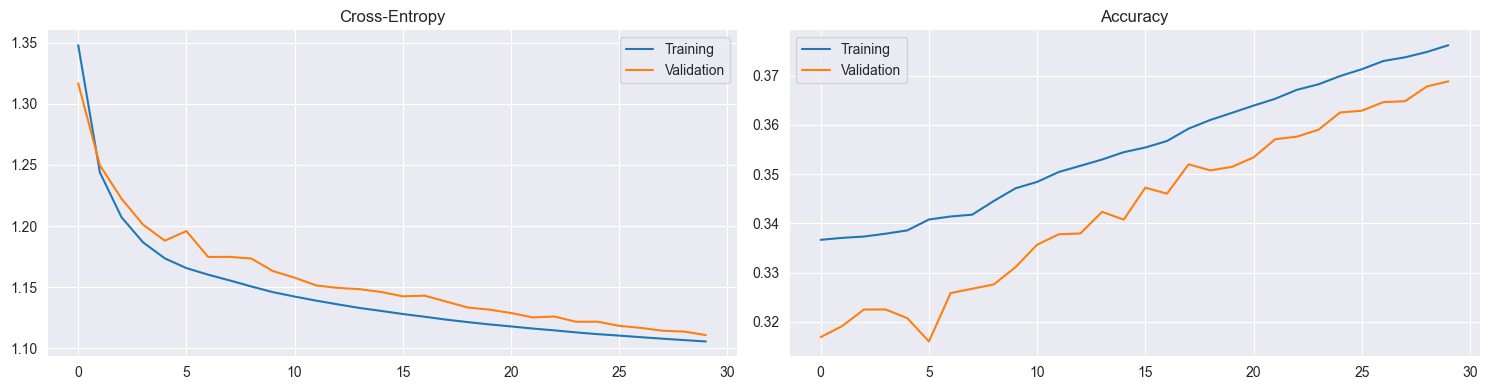

In [52]:
plot_learning_curves(metrics)

In [54]:
validation_steps= int(X_test.shape[0] / batch_size)
second_loss, second_accuracy, second_AUC = model.evaluate(test_seq_data, steps = validation_steps)

178/178 [==============================] - 89s 500ms/step - loss: 1.1109 - accuracy: 0.3689 - AUC: 0.5377


In [55]:
print(f'Transfer loss: {second_loss:.2f} | Transfer Accuracy : {second_accuracy:.2%} | Transfer AUC: {second_AUC:.2%}')

Transfer loss: 1.11 | Transfer Accuracy : 36.89% | Transfer AUC: 53.77%


### Fine Tune all Layers for Target Task

In [56]:
model.trainable = True

In [57]:
model.summary()

Model: "RNNStocks"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EmbedLayer (Embedding)      (None, None, 256)         47360     
                                                                 
 BiLSTM (Bidirectional)      (None, 2048)              10493952  
                                                                 
 BatchNormal (BatchNormaliza  (None, 2048)             8192      
 tion)                                                           
                                                                 
 FullConnected (Dense)       (None, 512)               1049088   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 BatchNormal2 (BatchNormaliz  (None, 512)              2048      
 ation)                                                  

In [58]:
# Name of the checkpoint files and save each weights at each epoch
# checkpoint_dir = './training_Daily'
# checkpoint_prefix = os.path.join(checkpoint_dir, "daily.h5")

checkpoint_dir = './training_checkpoints_CharWeights_V2'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback_weights=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    verbose=1,
    save_weights_only=True)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                               filepath='../CharModelDev/CharModel-v2/daily.h5',
                               verbose=1,
                               monitor='val_accuracy',
                               mode='max',
                               save_best_only=True)

early_stopping = EarlyStopping(monitor='val_AUC',
                               patience = 20,
                               mode='max',
                               restore_best_weights=True)
csv_logs = tf.keras.callbacks.CSVLogger('./daily_log.csv', separator=",", append=True)

In [59]:
base_learning_rate = 0.01
model.compile(optimizer =tf.keras.optimizers.Adam(lr=base_learning_rate / 10), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
          metrics=['accuracy',  tf.keras.metrics.AUC(name='AUC', multi_label=True)])

In [69]:
from datetime import datetime

datetime.datetime(2024, 3, 29, 12, 3, 19, 490352)

In [73]:
time_start = datetime.now()
print(time_start)
epochs = 100 - (history.epoch[-1] + 1) 
start = time.time()
fine_tuned_history = model.fit(train_seq_data, epochs=epochs, initial_epoch=(history.epoch[-1] + 1),workers = -1,
                    verbose = 1, validation_data=(test_seq_data),
                    callbacks=[checkpoint_callback, early_stopping, csv_logs])
end = time.time()
time_send = datetime.now()
print(time_send)
print("Time took {:3.1f} min".format((end-start)/60))

2024-03-29 12:09:21.868093
Epoch 31/70
3220/3220 [==============================] - ETA: 0s - loss: 1.0904 - accuracy: 0.4276 - AUC: 0.5005
Epoch 31: val_accuracy improved from -inf to 0.18662, saving model to ../CharModelDev/CharModel-v2\daily.h5
3220/3220 [==============================] - 9397s 3s/step - loss: 1.0904 - accuracy: 0.4276 - AUC: 0.5005 - val_loss: 59.9518 - val_accuracy: 0.1866 - val_AUC: 0.5000
Epoch 32/70
3220/3220 [==============================] - ETA: 0s - loss: 1.0796 - accuracy: 0.4298 - AUC: 0.4992
Epoch 32: val_accuracy improved from 0.18662 to 0.57268, saving model to ../CharModelDev/CharModel-v2\daily.h5
3220/3220 [==============================] - 9226s 3s/step - loss: 1.0796 - accuracy: 0.4298 - AUC: 0.4992 - val_loss: 4.0430 - val_accuracy: 0.5727 - val_AUC: 0.5000
Epoch 33/70
3220/3220 [==============================] - ETA: 0s - loss: 1.0823 - accuracy: 0.4284 - AUC: 0.4980
Epoch 33: val_accuracy did not improve from 0.57268
3220/3220 [=================

In [200]:
score = model.evaluate((test_seq_data), verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test AUC:', score[2])

89/89 [==============================] - 50s 564ms/step - loss: 0.6948 - accuracy: 0.5318 - AUC: 0.5123
Test loss: 0.6948203444480896
Test accuracy: 0.5317766666412354
Test AUC: 0.5122969746589661


In [201]:
score = model.evaluate((infer_seq_data), verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test AUC:', score[2])

44/44 [==============================] - 25s 569ms/step - loss: 0.6873 - accuracy: 0.3913 - AUC: 0.5152
Test loss: 0.6873216032981873
Test accuracy: 0.39133521914482117
Test AUC: 0.5152168273925781


In [99]:
fine_tuned = pd.DataFrame(fine_tuned_history.history)
df = pd.concat([metrics, fine_tuned]).reset_index(drop = 1)
df.index +=1

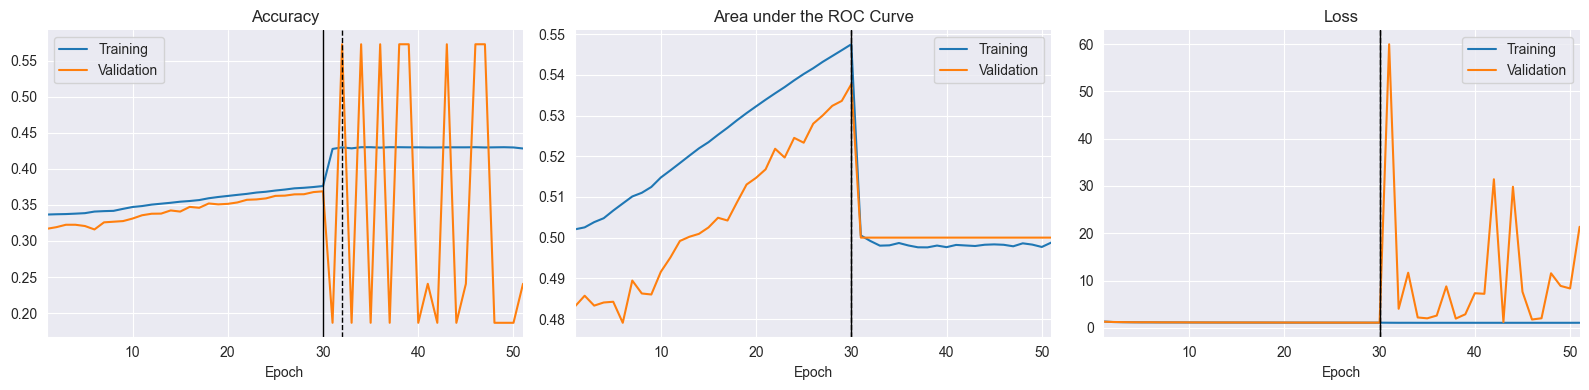

In [100]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))
#ACCURACY
df1 = (df[['accuracy', 'val_accuracy']]
       .rename(columns={'accuracy': 'Training',
                        'val_accuracy': 'Validation'}))
df1.plot(ax=axes[0], title='Accuracy', xlim=(1, len(df)))
axes[0].axvline(df.val_accuracy.idxmax(), ls='--', lw=1, c='k')
axes[0].axvline(len(metrics), ls='-', lw=1, c='k')
#AUC
df2 = (df[['AUC', 'val_AUC']]
       .rename(columns={'AUC': 'Training',
                        'val_AUC': 'Validation'}))
df2.plot(ax=axes[1], title='Area under the ROC Curve', xlim=(1, len(df)))

axes[1].axvline(df.val_AUC.idxmax(), ls='--', lw=1, c='k')
axes[1].axvline(len(metrics), ls='-', lw=1, c='k')
#LOSS
df2 = (df[['loss', 'val_loss']]
       .rename(columns={'loss': 'Training',
                        'val_loss': 'Validation'}))
df2.plot(ax=axes[2], title='Loss', xlim=(1, len(df)))

axes[2].axvline(df.val_loss.idxmin(), ls='--', lw=1, c='k')
axes[2].axvline(len(metrics), ls='-', lw=1, c='k')
for i in [0, 1, 2]:
    axes[i].set_xlabel('Epoch')

sns.despine()
fig.tight_layout()

In [103]:
# for ax in axes:
#     ax.axvline(10, ls='--', lw=1, c='k')
#     ax.legend(['Training', 'Validation', 'Start Fine Tuning'])
#     ax.set_xlabel('Epoch')

### Post FineTuning Analysis

In [104]:
tf.config.experimental.list_logical_devices()[-1]

LogicalDevice(name='/device:GPU:0', device_type='GPU')

In [176]:
#Load the models and accesories
with tf.device(tf.config.experimental.list_logical_devices()[-1]):
    
    HeNormal = tf.keras.initializers.he_normal()
    # weights = tf.keras.models.load_model('../CharModelDev/CharModel-v2/daily.h5', custom_objects={'HeNormal': HeNormal},compile=False).get_weights()
    daily_v3 = tf.keras.models.load_model('../CharModelDev/CharModel-v2/daily.h5', compile=False)
    # daily_v3.set_weights(weights)

In [ ]:
# #Compile then load weights
# ChaRmodel = create_language_model(None, 185)
# weights_dir = './training_checkpoints_CharWeights_V2'
# print(tf.train.latest_checkpoint(weights_dir))

# ChaRmodel.load_weights(tf.train.latest_checkpoint(weights_dir))

In [133]:
score = daily_v3.evaluate((test_seq_data), verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test AUC:', score[2])

178/178 [==============================] - 102s 556ms/step - loss: 4.0430 - accuracy: 0.5727 - AUC: 0.5000
Test loss: 4.042952060699463
Test accuracy: 0.5726825594902039
Test AUC: 0.5


In [134]:
score = daily_v3.evaluate((infer_seq_data), verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test AUC:', score[2])

89/89 [==============================] - 54s 583ms/step - loss: 4.4383 - accuracy: 0.4270 - AUC: 0.5000
Test loss: 4.438314437866211
Test accuracy: 0.42696627974510193
Test AUC: 0.5


In [147]:
y_test_pred =  daily_v3.predict((test_seq_data), verbose=1)

178/178 [==============================] - 102s 564ms/step


In [148]:
y_infer_pred =  daily_v3.predict((infer_seq_data), verbose=1)

89/89 [==============================] - 55s 607ms/step


In [145]:
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix)

def evaluate(y_true, y_pred):
    # labels = ['buy', 'hold', 'sell']
    # mapping = {'buy': 2, 'sell': 0, 'none':1, 'hold': 1}
    # def map_func(x):
    #     return mapping.get(x, 1)

    # y_true = np.vectorize(map_func)(y_true)
    # y_pred = np.vectorize(map_func)(y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')

    # Generate accuracy report
    unique_labels = set(y_true)  # Get unique labels

    for label in unique_labels:
        label_indices = [i for i in range(len(y_true))
                         if y_true[i] == label]
        label_y_true = [y_true[i] for i in label_indices]
        label_y_pred = [y_pred[i] for i in label_indices]
        accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {label}: {accuracy:.3f}')

    # Generate classification report
    class_report = classification_report(y_true=y_true, y_pred=y_pred)
    print('\nClassification Report:')
    print(class_report)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)
    print('\nConfusion Matrix:')
    print(conf_matrix)

In [141]:
evaluate(y_true = y_test.values, y_pred = )

ticker  time      
A       2019-07-11    1
        2019-07-12    1
        2019-07-16    1
        2019-07-17    1
        2019-07-18    0
                     ..
ZTS     2019-07-23    1
        2019-07-26    1
        2019-07-29    1
        2019-07-30    1
        2019-07-31    1
Name: Signal, Length: 5697, dtype: int64

In [149]:
y_test_pred

array([[2.2505678e-06, 9.9230754e-01, 7.6901917e-03],
       [2.2503064e-06, 9.9230874e-01, 7.6890085e-03],
       [2.2506563e-06, 9.9230778e-01, 7.6899477e-03],
       ...,
       [2.2511877e-06, 9.9230349e-01, 7.6942565e-03],
       [2.2512809e-06, 9.9230301e-01, 7.6947226e-03],
       [2.2509169e-06, 9.9230814e-01, 7.6896092e-03]], dtype=float32)

In [177]:
padded_sample = 'MSFT rallying after last earnings call' 
padded_sample = '<s>' + padded_sample + '<\s' + chr(0) * 20
print(padded_sample)
padded_sample = [i.encode('utf-8') for i in padded_sample]
padded_sample = tokenizer.texts_to_sequences(padded_sample)
print(padded_sample)
padded_sample = tf.squeeze(padded_sample)
padded_sample = tf.expand_dims(padded_sample, 0).numpy()
padded_sample.shape

<s>MSFT rallying after last earnings call<\s                    
[[31], [86], [33], [48], [54], [41], [55], [3], [85], [68], [79], [79], [92], [76], [81], [74], [3], [68], [73], [87], [72], [85], [3], [79], [68], [86], [87], [3], [72], [68], [85], [81], [76], [81], [74], [86], [3], [70], [68], [79], [79], [31], [63], [86], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]


(1, 64)

In [178]:
print(daily_v3(sample).numpy())
print('vs')
print(daily_v3(padded_sample).numpy())
print(np.argmax(daily_V2(sample).numpy(), axis = 1),': ',np.max(daily_V2(sample).numpy(), axis = 1))

[[2.2450818e-06 9.9229795e-01 7.6998444e-03]]
vs
[[2.2450818e-06 9.9229795e-01 7.6998444e-03]]
[1] :  [0.99229795]
